# Analysis of [Google Play Store reviews](https://www.kaggle.com/datasets/prakharrathi25/google-play-store-reviews) by **Kacper Piątkowski**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

class colors:
    POSITIVE = '\033[92m'
    NEGATIVE = '\033[91m'
    RESET = '\033[0m'

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def lines(text=''): return f'{text:-^70}'

iterations = 2000

gplay_df = pd.read_csv('reviews.csv')
gplay_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaN,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo
2,gp:AOqpTOEMCkJB8Iq1p-r9dPwnSYadA5BkPWTf32Z1azu...,Sudhakar .S,https://play-lh.googleusercontent.com/a-/AOh14...,Very costly for the premium version (approx In...,1,0,NaN,2020-10-27 08:18:40,NaN,NaN,newest,com.anydo
3,gp:AOqpTOGFrUWuKGycpje8kszj3uwHN6tU_fd4gLVFy9z...,SKGflorida@bellsouth.net DAVID S,https://play-lh.googleusercontent.com/-75aK0WF...,"Used to keep me organized, but all the 2020 UP...",1,0,NaN,2020-10-26 13:28:07,What do you find troublesome about the update?...,2020-10-26 14:58:29,newest,com.anydo
4,gp:AOqpTOHls7DW8wmDFzTkHwxuqFkdNQtKHmO6Pt9jhZE...,Louann Stoker,https://play-lh.googleusercontent.com/-pBcY_Z-...,Dan Birthday Oct 28,1,0,5.6.0.7,2020-10-26 06:10:50,NaN,NaN,newest,com.anydo


In [65]:
dropped = ['reviewId','userName','userImage','reviewCreatedVersion','at','repliedAt','sortOrder']
print(lines('Dropping columns'))
print(*dropped)
print(lines())
gplay_df = gplay_df.drop(columns=dropped)
print(f'Dataset size: {gplay_df.shape}')
gplay_df.head()

---------------------------Dropping columns---------------------------
reviewId userName userImage reviewCreatedVersion at repliedAt sortOrder
----------------------------------------------------------------------
Dataset size: (12495, 5)


,content,score,thumbsUpCount,replyContent,appId
0,I cannot open the app anymore,1,0,NaN,com.anydo
1,I have been begging for a refund from this app...,1,0,"Please note that from checking our records, yo...",com.anydo
2,Very costly for the premium version (approx In...,1,0,NaN,com.anydo
3,"Used to keep me organized, but all the 2020 UP...",1,0,What do you find troublesome about the update?...,com.anydo
4,Dan Birthday Oct 28,1,0,NaN,com.anydo


# Note:
    First of all I wanted to clean up the dataset, so I dropped some of the columns that made no sense to analize like userId, userImage and so on.

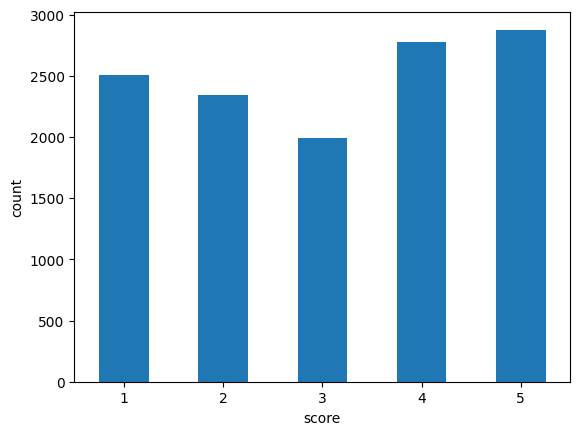

In [66]:
gplay_df.score.value_counts().sort_index().plot(kind='bar', rot=0, xlabel='score', ylabel='count')
plt.show()

# Note:
    We can see that there are mostly positive scores given by the users and the score '3' is least used - which is good for us - because we will remove all the reviews with neutral sentiment - meaning we will have more data to analyze.

[]

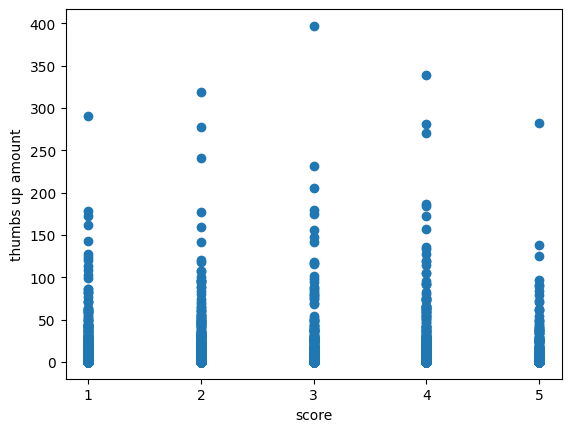

In [67]:
plt.scatter(gplay_df.score, gplay_df.thumbsUpCount)
plt.xlabel('score')
plt.ylabel('thumbs up amount')
plt.xticks(gplay_df.score.unique())
plt.plot()

# Note:
    There's no correlation between thumbs up amount and the score - but we can see that there are a lot of 3-scored reviews with lots of thumbs up (which can be viewed as weird - because it has neutral sentiment, but the 3-scored reviews mostly contain many pros and cons - meaning they could give a good overall rating of the product)

In [68]:
print(lines('removing punctuation'))

gplay_df['content'] = gplay_df['content'].apply(lambda x: remove_punctuation(x) if isinstance(x, str) else '')
print(gplay_df[gplay_df['content'].isna()])

print(lines('removing neutral sentiment'))

print(f'Amount of rows in which rating column is 3: {sum(gplay_df["score"] == 3)}')
gplay_df = gplay_df[gplay_df.score != 3]
print(f'Amount of rows in which rating column is 3: {sum(gplay_df["score"] == 3)}')

print(lines('classifing scores'))

print(f'Amount of ratings with ratting different than -1 or 1: {sum(gplay_df["score"]**2 != 1)}')
gplay_df.loc[gplay_df["score"] <= 2, "score"] = -1
gplay_df.loc[gplay_df["score"] >= 4, "score"] = 1
print(f'Amount of ratings with ratting different than -1 or 1: {sum(gplay_df["score"]**2 != 1)}')

print(lines(''))

-------------------------removing punctuation-------------------------
Empty DataFrame
Columns: [content, score, thumbsUpCount, replyContent, appId]
Index: []
----------------------removing neutral sentiment----------------------
Amount of rows in which rating column is 3: 1991
Amount of rows in which rating column is 3: 0
--------------------------classifing scores---------------------------
Amount of ratings with ratting different than -1 or 1: 7998
Amount of ratings with ratting different than -1 or 1: 0
----------------------------------------------------------------------


# Note:
    Next up I classified the data:
1) I dropped all the rows in which the score was 3 (so the reviews were having neutral sentiment [there were 5 possible scores: 1,2,3,4,5])
2) Next up I've changed all positive reviews ($\geq$ 4) to 1 and negative ($\leq$ 2) to -1 

In [69]:
smaller_df = gplay_df[:]
X_train, X_test, y_train, y_test = train_test_split(smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
print(np.shape(X_train))

(7352, 10014)


# Note:
    I made the vectorization using the training dataset (0.3 of the original dataset) and received a vector of size (7352, 10014).

In [70]:
model = LogisticRegression(max_iter=iterations)
model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [71]:
coefs = model.coef_.reshape(-1, 1)
new_coefs = np.array([coef[0] for coef in coefs])

most_positive_idx = (-new_coefs).argsort()[:10]
most_negative_idx = new_coefs.argsort()[:10]

most_positive = [vectorizer.get_feature_names_out()[i] for i in most_positive_idx]
most_negative = [vectorizer.get_feature_names_out()[i] for i in most_negative_idx]

print('Most positive words:', *most_positive)
print('Most negative words:', *most_negative)

Most positive words: excellent amazing great love best helps nice easy awesome helpful
Most negative words: useless uninstalled disappointed complicated uninstall not deleted horrible expensive worst


# Note:
    We can see that the positive and the negative words fit nicely in their category (even though there are some exceptions like 'not' in negative words [of course we can say that the app is 'not bad'] but by analyzing word by word we can't analyze sequences like 'not bad')

In [72]:
y_pred_prob = model.predict_proba(X_test)

negative = y_pred_prob[:, 0]
positive = y_pred_prob[:, 1]

most_negative_idx = (-negative).argsort()[:5]
most_positive_idx = positive.argsort()[-5:]

print(lines())
print('Most negative reviews row numbers:', *most_negative_idx)
print('Most positive reviews row numbers:', *most_positive_idx)
print(lines())

print(f'{colors.NEGATIVE}red {colors.RESET} means a negative review (value == -1)')
print(f'{colors.POSITIVE}green {colors.RESET} means a positive review (value == 1)')

_ = 'Most positive reviews according to probability'
print(lines(_))

for idx in most_positive_idx:
    color = colors.POSITIVE if np.array(smaller_df['score'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}', np.array(smaller_df['content'])[idx])

_ = _.replace('positive', 'negative')
print(lines(_))

for idx in most_negative_idx:
    color = colors.POSITIVE if np.array(smaller_df['score'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}',np.array(smaller_df['content'])[idx])

print(lines())
print(f'Model score: {model.score(X_test, y_test)}')
print(lines())

----------------------------------------------------------------------
Most negative reviews row numbers: 2563 2899 117 809 1882
Most positive reviews row numbers: 3104 2817 2139 1563 562
----------------------------------------------------------------------
red  means a negative review (value == -1)
green  means a positive review (value == 1)
------------Most positive reviews according to probability------------
	3104: Really love this I enjoy the complexity and the fact that you can buy rewards for keeping up with stuff and that there and consequences for not doing your dailies
	2817: I love thats application but l Will to be in spanish version I love thats application but l Will be like to be in spanish version
	2139: Helps me accomplish my tasks
	1563: Been using this app for 3 years
	562: This app is good I use it daily and it runs my life I have too many tasks though and anydos plan my day feature is good at forcing me to postpone stuff to next week repeatedly Pls add a built in 

# Note:
    From the reviews we can see that the model correctly predicted positive reviews (as they are also positive in the original dataset) and when it comes to most negative reviews one of the predicted as negative (2899) was originally positive (possibly because the review is quite long and the words density makes the prediction worse)
    
    What I found really interesting is that most of the positive requests seem shorter than the negative ones (of course there's review 562 - but there's always exception to the rule)

    The model score was 0.857 which is a quite high of a score - meaning that the data was correcly split.

In [73]:
significant_words = [*most_positive, *most_negative]

In [74]:
X_train, X_test, y_train, y_test = train_test_split(smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer(vocabulary=significant_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
model.fit(X_train, y_train)

coefs = model.coef_.reshape(-1, 1)
new_coefs = np.array([coef[0] for coef in coefs])

most_positive_idx = (-new_coefs).argsort()[:10]
most_negative_idx = new_coefs.argsort()[:10]

most_positive = [vectorizer.get_feature_names_out()[i] for i in most_positive_idx]
most_negative = [vectorizer.get_feature_names_out()[i] for i in most_negative_idx]

print('Most positive words:', *most_positive)
print('Most negative words:', *most_negative, end='\n\n')
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)
negative = y_pred_prob[:, 0]
positive = y_pred_prob[:, 1]

most_negative_idx = (-negative).argsort()[:5]
most_positive_idx = positive.argsort()[-5:]
print('Most positive reviews row numbers:', *most_positive_idx)
print('Most negative reviews row numbers:', *most_negative_idx, end='\n\n')

print(f'{colors.NEGATIVE}red {colors.RESET} means a negative review (value == -1)')
print(f'{colors.POSITIVE}green {colors.RESET} means a positive review (value == 1)')

_ = 'Most positive reviews according to probability'
print(f'\n{_:-^70}')
for idx in most_positive_idx:
    color = colors.POSITIVE if np.array(smaller_df['score'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}', np.array(smaller_df['content'])[idx])

_ = _.replace('positive', 'negative')
print(f'\n{_:-^70}')
for idx in most_negative_idx:
    color = colors.POSITIVE if np.array(smaller_df['score'])[idx] == 1 else colors.NEGATIVE
    print(f'\t{color}{idx}:{colors.RESET}',np.array(smaller_df['content'])[idx])
print('-'*70)

print(f'Model score: {model.score(X_test, y_test)}')

Most positive words: helps excellent helpful amazing easy best nice awesome love great
Most negative words: useless uninstalled disappointed uninstall deleted horrible worst expensive complicated not

Most positive reviews row numbers: 845 2760 2817 990 562
Most negative reviews row numbers: 2899 1367 1450 1617 2130

red  means a negative review (value == -1)
green  means a positive review (value == 1)

------------Most positive reviews according to probability------------
	845: For sure this app is good enough but After a year of usage they added reminder feature to a premium access Without reminders your app is useless Thanks a lot Even comments went to premium Completely useless app
	2760: Glitches abound Inputs ignored not given options to make habits at points
	2817: I love thats application but l Will to be in spanish version I love thats application but l Will be like to be in spanish version
	990: I will use other app I will not pay
	562: This app is good I use it daily and it 

# Note:
    Using the limited dictionary we achieved worse results - the model score is now 0.689 (19.57% worse than the previous one).
    
    The positive reviews even though predicted as the most positive by the model were mostly negative (3/5) in the original dataset and the same applies to the negative ones - even though predicted as the most negative they were mostly positive (and if we read them - e.x. 1450 it's obvious that they are positive)

    The most positive/negative predictions may be bad because we took a bad vocabulary (or to short of a vocabulary). If we want to increate the score of the predictions we should think about adding more words to vocabulary.

In [75]:
coefs = np.array([coef for coef in model.coef_[0]])
idx = coefs.argsort()
for i in idx:
    color = colors.POSITIVE if coefs[i] > 0 else colors.NEGATIVE
    print(f'{color}{round(coefs[i],5):>8}{colors.RESET}: {vectorizer.get_feature_names_out()[i]}')

-3.24225: useless
-2.75973: uninstalled
-2.65138: disappointed
-2.49819: uninstall
-2.31202: deleted
-2.11415: horrible
-1.91239: worst
-1.53037: expensive
-1.49108: complicated
-1.35128: not
 1.29826: great
 1.36424: love
 1.54518: awesome
 1.64783: nice
 1.78303: best
 1.83611: easy
 1.92519: amazing
 1.94693: helpful
 2.12569: excellent
 2.32644: helps


# Note:
    We can see that the most negative words were: useless, uninstalled, disappointed - all having negative meaning in english

    When it comes to positive words they were: helps, excellent, amazing - all of them having a very positive meaning in english
    
    So the model got the positive and negative words impacts right (although the word 'not' could have double meaning as described previously).

In [76]:
X_train, X_test, y_train, y_test = train_test_split(smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
print(lines())
print('Timing fit of model without limited dictionary...')
%timeit model.fit(X_train, y_train)
print(f'Model score: {model.score(X_test, y_test)}', end='\n\n')

X_train, X_test, y_train, y_test = train_test_split(smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)
vectorizer = CountVectorizer(vocabulary=significant_words)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)
model = LogisticRegression(max_iter=iterations)
print(lines())
print('Timing fit of model with limited dictionary...')
%timeit model.fit(X_train, y_train)
print(f'Model score: {model.score(X_test, y_test)}')
print(lines())

----------------------------------------------------------------------
Timing fit of model without limited dictionary...
829 ms ± 8.02 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Model score: 0.8575507614213198

----------------------------------------------------------------------
Timing fit of model with limited dictionary...
17.5 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Model score: 0.6897208121827412
----------------------------------------------------------------------


# Note:
    The time difference the model in which we used predefined vocabulary is enormous (almost 20x) - because we do not have to analyze all of the words but only ones from the given vocabulary. 
    Of course because of that the score is worse (but we discussed it before, as it is the same model as previously)

# Note: We now begin comparing different classifiers

In [77]:
# HELPER FUNCTIONS

def print_rates(tn, fp, fn, tp):
    print(f'True negative: {tn}')
    print(f'False positive: {fp}')
    print(f'False negative: {fn}')
    print(f'True positive: {tn}')
    # True positive and true negative rates
    tpr_lr = round(tp/(tp+fn), 4)
    tnr_lr = round(tn/(tn+fp), 4)
    print(f'True positive rate: {tpr_lr}\nTrue negative rate: {tnr_lr}')
    print(lines())

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

# Vectorizing the text data
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

# Training the model
lr = LogisticRegression(max_iter=iterations)
print(lines())
print('Timing fit of logistic regression model...')
%timeit lr.fit(ctmTr, y_train)

# Accuracy score
lr_score = lr.score(X_test_dtm, y_test)
print(lines())
print("Results for Logistic Regression with CountVectorizer")
print(lines())
print(f'Model score: {lr_score}')

# Predicting the labels for test data
y_pred_lr = lr.predict(X_test_dtm)

# Confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print_rates(tn, fp, fn, tp)


----------------------------------------------------------------------
Timing fit of logistic regression model...
849 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----------------------------------------------------------------------
Results for Logistic Regression with CountVectorizer
----------------------------------------------------------------------
Model score: 0.8575507614213198
True negative: 1215
False positive: 257
False negative: 192
True positive: 1215
True positive rate: 0.8857
True negative rate: 0.8254
----------------------------------------------------------------------


# Note:
Logistic Regression with CountVectorizer achieved: 
* score of 0.857
* true positive rate of 0.886
* true negative rate of 0.825
* it took about 850ms 

It achieved overall quite high of a score, but maybe we can do better with different models

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

# Vectorizing the text data
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

# Training the model
svcl = svm.SVC()
print(lines())
print('Timing fit of Support Vector Machine...')
%timeit svcl.fit(ctmTr, y_train)

# Accuracy score
svcl_score = svcl.score(X_test_dtm, y_test)
print(lines())
print("Results for Support Vector Machine with CountVectorizer")
print(lines())
print(f'Model score: {svcl_score}')

# Predicting the labels for test data
y_pred_sv = svcl.predict(X_test_dtm)

# Confusion matrix
cm_sv = confusion_matrix(y_test, y_pred_sv)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sv).ravel()
print_rates(tn, fp, fn, tp)


----------------------------------------------------------------------
Timing fit of Support Vector Machine...
7.32 s ± 187 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----------------------------------------------------------------------
Results for Support Vector Machine with CountVectorizer
----------------------------------------------------------------------
Model score: 0.8451776649746193
True negative: 1238
False positive: 234
False negative: 254
True positive: 1238
True positive rate: 0.8488
True negative rate: 0.841
----------------------------------------------------------------------


# Note:
Support Vector Machine with CountVectorizer achieved: 
* score of 0.845 (**worse** than Logistic Regression) 
* true positive rate of 0.848 (**worse** than Logistic Regression)
* true negative rate of 0.841 (**better** than Logistic Regression)
* it took about 7.32s (almost 10x **longer** than Logistic Regression)

Comparing it with Logistic Regression it achieved worse overall score in longer time. On the positive side it achieved a higher true-negative ratio.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

# Vectorizing the text data
cv = CountVectorizer()
ctmTr = cv.fit_transform(X_train)
X_test_dtm = cv.transform(X_test)

# Training the model
knn = KNeighborsClassifier(n_neighbors=5)
print(lines())
print('Timing fit of K Neighbors Classifier with neighbors=5...')
%timeit knn.fit(ctmTr, y_train)

# Accuracy score
knn_score = knn.score(X_test_dtm, y_test)
print(lines())
print("Results for KNN Classifier with CountVectorizer")
print(lines())
print(f'Model score: {knn_score}')

# Predicting the labels for test data
y_pred_knn = knn.predict(X_test_dtm)

#Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()
print_rates(tn, fp, fn, tp)

----------------------------------------------------------------------
Timing fit of K Neighbors Classifier with neighbors=5...
1.29 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
----------------------------------------------------------------------
Results for KNN Classifier with CountVectorizer
----------------------------------------------------------------------
Model score: 0.6824238578680203
True negative: 633
False positive: 839
False negative: 162
True positive: 633
True positive rate: 0.9036
True negative rate: 0.43
----------------------------------------------------------------------


# Note:
K Neighbors Classifier with CountVectorizer achieved:
* score of 0.682 (**worse** than the previous two) 
* true positive rate of 0.903 (**better** than the previous two)
* true negative rate of 0.43 (**worse** than the previous two)
* it took about 1.29ms (almost 900x **faster** than Logistic Regression)

Comparing it with the previous two it achieved worse overall score but with much less time taken. Depending on what we want to achieve it might be a good choice. Of course we could improve the score increasing the number of neighbours. 

### **Best overall score was achieved by Logistic Regression with CountVectorizer**

# Note: using TF-IDF instead of CountVectorizer

In [81]:
# Logistic Regression with TF-IDF

X_train, X_test, y_train, y_test = train_test_split(
    smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

#tfidf vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
lr_score = lr.score(X_test_vec, y_test)
print(lines())
print("Results for Logistic Regression with TF-IDF")
print(lr_score)
y_pred_lr = lr.predict(X_test_vec)
#Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()
print_rates(tn, fp, fn, tp)

----------------------------------------------------------------------
Results for Logistic Regression with TF-IDF
0.8559644670050761
True negative: 1239
False positive: 233
False negative: 221
True positive: 1239
True positive rate: 0.8685
True negative rate: 0.8417
----------------------------------------------------------------------


In [82]:
# Support Vector Machine with TF-IDF

X_train, X_test, y_train, y_test = train_test_split(
    smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
svcl = svm.SVC(kernel='rbf')
svcl.fit(X_train_vec, y_train)

svcl_score = svcl.score(X_test_vec, y_test)
print(lines())
print("Results for Support Vector Machine with TF-IDF")
print(svcl_score)
y_pred_sv = svcl.predict(X_test_vec)

# Confusion matrix
cm_sv = confusion_matrix(y_test, y_pred_sv)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_sv).ravel()
print_rates(tn, fp, fn, tp)


----------------------------------------------------------------------
Results for Support Vector Machine with TF-IDF
0.8635786802030457
True negative: 1264
False positive: 208
False negative: 222
True positive: 1264
True positive rate: 0.8679
True negative rate: 0.8587
----------------------------------------------------------------------


In [83]:
# K Neighbors Classifier with TF-IDF

X_train, X_test, y_train, y_test = train_test_split(
    smaller_df['content'], smaller_df['score'], test_size=0.3, random_state=44)

vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_vec, y_train)

knn_score = knn.score(X_test_vec, y_test)
print(lines())
print("Results for KNN Classifier with TF-IDF")
print(knn_score)
y_pred_knn = knn.predict(X_test_vec)

# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()
print_rates(tn, fp, fn, tp)


----------------------------------------------------------------------
Results for KNN Classifier with TF-IDF
0.5663071065989848
True negative: 190
False positive: 1282
False negative: 85
True positive: 190
True positive rate: 0.9494
True negative rate: 0.1291
----------------------------------------------------------------------


# Note:
After checking the same classifiers with TF-IDF we achieved interesting results.
The best overall score with TF-IDF was achieved by SVM:
* score of 0.863 (**better** than Logistic Regression with CountVectorizer)
* true positive rate of 0.867 (**worse** than Logistic Regression with CountVectorizer)
* true negative rate of 0.858 (**better** than Logistic Regression with CountVectorizer)